<a href="https://colab.research.google.com/github/JVR27XD/MobileSAM/blob/main/NanoSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install numpy==1.24.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 115.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.4.0 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24

In [4]:
# 🚀 1️⃣ Clonar el repo de NanoSAM
%%shell
if [ ! -e nanosam ]; then
    git clone https://github.com/NVIDIA-AI-IOT/nanosam.git
fi

# 🚀 2️⃣ Cambiar a carpeta nanosam
%cd /content/nanosam

# 🚀 3️⃣ Instalar onnxruntime-gpu
%%shell
if type nvidia-smi > /dev/null 2>&1; then
    pip install onnxruntime-gpu==1.17 --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
else
    pip install onnxruntime
fi

# 🚀 4️⃣ Descargar encoder/decoder .onnx
%%shell
mkdir -p data

if [ ! -e data/mobile_sam_mask_decoder.onnx ]; then
    curl -kL -o data/mobile_sam_mask_decoder.onnx 'https://drive.google.com/uc?export=download&id=1jYNvnseTL49SNRx9PDcbkZ9DwsY8up7n'
fi

if [ ! -e data/resnet18_image_encoder.onnx ]; then
    curl -kL -o data/resnet18_image_encoder.onnx 'https://drive.google.com/uc?export=download&id=14-SsvoaTl-esC3JOzomHDnI9OGgdO2OR'
fi


/bin/bash: line 6: fg: no job control
/bin/bash: line 9: fg: no job control
Looking in indexes: https://pypi.org/simple, https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
/bin/bash: line 17: fg: no job control


In [8]:
# Descargar encoder y decoder .onnx
%%shell
mkdir -p data

gdown --id 14-SsvoaTl-esC3JOzomHDnI9OGgdO2OR -O data/resnet18_image_encoder.onnx
gdown --id 1jYNvnseTL49SNRx9PDcbkZ9DwsY8up7n -O data/mobile_sam_mask_decoder.onnx


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=14-SsvoaTl-esC3JOzomHDnI9OGgdO2OR

but Gdown can't. Please check connections and permissions.
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with

CalledProcessError: Command 'mkdir -p data

gdown --id 14-SsvoaTl-esC3JOzomHDnI9OGgdO2OR -O data/resnet18_image_encoder.onnx
gdown --id 1jYNvnseTL49SNRx9PDcbkZ9DwsY8up7n -O data/mobile_sam_mask_decoder.onnx
' returned non-zero exit status 1.

In [3]:
# 🚀 5️⃣ IMPORTS
import types
import sys
import PIL
import torch
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort

# 🚀 6️⃣ PATCH: Dummy torch2trt & tensorrt modules
torch2trt = types.ModuleType("torch2trt")
class TRTModule:
    def __init__(self, *args, **kwargs):
        raise ImportError("torch2trt is not available")
torch2trt.TRTModule = TRTModule
sys.modules["torch2trt"] = torch2trt
sys.modules["tensorrt"] = types.ModuleType("tensorrt")

# 🚀 7️⃣ Funciones utilitarias
from nanosam.utils.predictor import preprocess_points, upscale_mask

def preprocess_image(image, size: int = 512):
    if isinstance(image, np.ndarray):
        image = PIL.Image.fromarray(image)

    image_mean = torch.tensor([123.675, 116.28, 103.53])[:, None, None]
    image_std = torch.tensor([58.395, 57.12, 57.375])[:, None, None]

    image_pil = image
    aspect_ratio = image_pil.width / image_pil.height
    if aspect_ratio >= 1:
        resize_width = size
        resize_height = int(size / aspect_ratio)
    else:
        resize_height = size
        resize_width = int(size * aspect_ratio)

    image_pil_resized = image_pil.resize((resize_width, resize_height))
    image_np_resized = np.asarray(image_pil_resized).copy()
    image_torch_resized = torch.from_numpy(image_np_resized).permute(2, 0, 1)
    image_torch_resized_normalized = (image_torch_resized.float() - image_mean) / image_std
    image_tensor = torch.zeros((1, 3, size, size))
    image_tensor[0, :, :resize_height, :resize_width] = image_torch_resized_normalized

    return image_tensor

def run_mask_decoder(mask_decoder_session, features, points=None, point_labels=None, mask_input=None):
    if points is not None:
        assert point_labels is not None
        assert len(points) == len(point_labels)

    image_point_coords = np.array([points], dtype=np.float32)
    image_point_labels = np.array([point_labels], dtype=np.float32)

    if mask_input is None:
        mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
        has_mask_input = np.array([0], dtype=np.float32)
    else:
        has_mask_input = np.array([1], dtype=np.float32)

    iou_predictions, low_res_masks = mask_decoder_session.run(
        ["iou_predictions", "low_res_masks"],
        {
            "image_embeddings": features,
            "point_coords": image_point_coords,
            "point_labels": image_point_labels,
            "mask_input": mask_input,
            "has_mask_input": has_mask_input,
        }
    )
    iou_predictions = torch.from_numpy(iou_predictions.astype(np.float32)).clone()
    low_res_masks = torch.from_numpy(low_res_masks.astype(np.float32)).clone()

    return iou_predictions, low_res_masks


In [5]:
class OnnxNanosamPredictor:
    def __init__(self,
            image_encoder_path: str,
            mask_decoder_path: str,
            image_encoder_size: int = 1024,
            orig_image_encoder_size: int = 1024,
        ):
        self.image_encoder_session = ort.InferenceSession(
            image_encoder_path,
            providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
        )
        self.mask_decoder_session = ort.InferenceSession(
            mask_decoder_path,
            providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
        )
        self.image_encoder_size = image_encoder_size
        self.orig_image_encoder_size = orig_image_encoder_size

    def set_image(self, image):
        self.image = image
        self.image_tensor = preprocess_image(image, self.image_encoder_size)
        self.features = self.image_encoder_session.run(
            ["image_embeddings"],
            {
                "image": self.image_tensor.numpy(),
            }
            )[0]

    def predict(self, points, point_labels, mask_input=None):
        points = preprocess_points(
            points,
            (self.image.height, self.image.width),
            self.orig_image_encoder_size
        )
        mask_iou, low_res_mask = run_mask_decoder(
            self.mask_decoder_session,
            self.features,
            points,
            point_labels,
            mask_input
        )

        hi_res_mask = upscale_mask(
            low_res_mask,
            (self.image.height, self.image.width)
        )

        return hi_res_mask, mask_iou, low_res_mask


In [6]:
class OnnxNanosamPredictor:
    def __init__(self,
            image_encoder_path: str,
            mask_decoder_path: str,
            image_encoder_size: int = 1024,
            orig_image_encoder_size: int = 1024,
        ):
        self.image_encoder_session = ort.InferenceSession(
            image_encoder_path,
            providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
        )
        self.mask_decoder_session = ort.InferenceSession(
            mask_decoder_path,
            providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
        )
        self.image_encoder_size = image_encoder_size
        self.orig_image_encoder_size = orig_image_encoder_size

    def set_image(self, image):
        self.image = image
        self.image_tensor = preprocess_image(image, self.image_encoder_size)
        self.features = self.image_encoder_session.run(
            ["image_embeddings"],
            {
                "image": self.image_tensor.numpy(),
            }
            )[0]

    def predict(self, points, point_labels, mask_input=None):
        points = preprocess_points(
            points,
            (self.image.height, self.image.width),
            self.orig_image_encoder_size
        )
        mask_iou, low_res_mask = run_mask_decoder(
            self.mask_decoder_session,
            self.features,
            points,
            point_labels,
            mask_input
        )

        hi_res_mask = upscale_mask(
            low_res_mask,
            (self.image.height, self.image.width)
        )

        return hi_res_mask, mask_iou, low_res_mask


In [7]:
# 🚀 9️⃣ Paths de los modelos
image_encoder_path = "data/resnet18_image_encoder.onnx"
mask_decoder_path = "data/mobile_sam_mask_decoder.onnx"

# 🚀 10️⃣ Crear predictor
predictor = OnnxNanosamPredictor(
    image_encoder_path,
    mask_decoder_path
)

# 🚀 11️⃣ Cargar imagen de prueba
image = PIL.Image.open("assets/my_image.jpg")  # Pon aquí tu imagen

# 🚀 12️⃣ Run image encoder
predictor.set_image(image)

# 🚀 13️⃣ Ejemplo de puntos de referencia
bbox = [100, 100, 850, 759]  # x0, y0, x1, y1

points = np.array([
    [bbox[0], bbox[1]],
    [bbox[2], bbox[3]]
])

point_labels = np.array([2, 3])  # Bounding box corners

# 🚀 14️⃣ Inference
mask, _, _ = predictor.predict(points, point_labels)
mask = (mask[0, 0] > 0).detach().cpu().numpy()

# 🚀 15️⃣ Visualizar resultado
plt.imshow(image)
plt.imshow(mask, alpha=0.5)

x = [bbox[0], bbox[2], bbox[2], bbox[0], bbox[0]]
y = [bbox[1], bbox[1], bbox[3], bbox[3], bbox[1]]
plt.plot(x, y, 'g-')
plt.axis('off')
plt.show()


InvalidProtobuf: [ONNXRuntimeError] : 7 : INVALID_PROTOBUF : Load model from data/resnet18_image_encoder.onnx failed:Protobuf parsing failed.

In [9]:
!pip install git+https://github.com/facebookresearch/segment-anything.git


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-lsd4oza3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-lsd4oza3
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=f36c955469a51ecea29e4bd2ce660747c65ad8cc36385838bed3670aa998e22d
  Stored in directory: /tmp/pip-ephem-wheel-cache-a6ugloq5/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [10]:
!python3 export_pt_to_onnx.py


📦 Cargando modelo .pt...
Traceback (most recent call last):
  File "/content/nanosam/export_pt_to_onnx.py", line 13, in <module>
    sam_model = sam_model_registry[model_type](checkpoint=pt_model_path)
                ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'vit_t'


In [ ]:
!pip install onnx


In [ ]:
!python3 -m nanosam.tools.export_sam_mask_decoder_onnx \
    --model-type vit_t \
    --checkpoint assets/mobile_sam.pt \
    --output data/mobile_sam_mask_decoder.onnx

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/content/nanosam/nanosam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with nanosam.mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/content/nanosam/nanosam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with 

In [ ]:
!python3 -m nanosam.tools.export_image_encoder_onnx \
    --checkpoint assets/mobile_sam.pt \
    --output data/tiny_vit_image_encoder.onnx \
    --input_size 1024 \
    --opset 17

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/content/nanosam/nanosam/tools/export_image_encoder_onnx.py", line 59, in <module>
    model.load_state_dict(torch.load(args.checkpoint)["model"])
                          ~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^
KeyError: 'model'


In [ ]:
!pip install nvidia-pyindex nvidia-tensorrt


In [ ]:
!python export_engine.py \
    --onnx_model_path=data/mobile_sam_mask_decoder.onnx \
    --engine_output_path=data/mobile_sam_mask_decoder.engine \
    --use_fp16 True


[06/19/2025-19:04:39] [TRT] [W] Detected layernorm nodes in FP16.
[06/19/2025-19:04:39] [TRT] [W] Running layernorm after self-attention with FP16 Reduce or Pow may cause overflow. Forcing Reduce or Pow Layers in FP32 precision, or exporting the model to use INormalizationLayer (available with ONNX opset >= 17) can help preserving accuracy.
✅ TensorRT engine successfully saved to data/mobile_sam_mask_decoder.engine


In [ ]:
encoder_session = ort.InferenceSession(
    "/content/nanosam/data/MobileSam_SAMEncoder.onnx",
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
)

In [ ]:
import onnxruntime as ort

# Ruta al encoder .onnx que descargaste
encoder_path = "/content/nanosam/data/MobileSam_SAMEncoder.onnx"

# Crear sesión ONNX Runtime
encoder_session = ort.InferenceSession(
    encoder_path,
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
)

print("✅ Encoder .onnx cargado correctamente")


✅ Encoder .onnx cargado correctamente


In [ ]:
from src.infer_mobile_sam_trt10_v5 import InferenceEngine

# Ruta a tu .engine
engine = InferenceEngine(
    trt_model_1 = "/content/nanosam/data/mobile_sam_mask_decoder.engine"
)

print("✅ Mask decoder .engine cargado correctamente")


✅ InferenceEngine MobileSAM (TRT 10.12 FINAL v3) initialized.
✅ Mask decoder .engine cargado correctamente


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Cargar imagen
image_path = "/content/nanosam/assets/dogs.jpg"  # usa tu imagen
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Normalización
image_mean = np.array([123.675, 116.28, 103.53])[:, None, None]
image_std = np.array([58.395, 57.12, 57.375])[:, None, None]

# Resize
size = 1024
h, w, _ = image.shape
aspect_ratio = w / h

if aspect_ratio >= 1:
    resize_w = size
    resize_h = int(size / aspect_ratio)
else:
    resize_h = size
    resize_w = int(size * aspect_ratio)

image_resized = cv2.resize(image, (resize_w, resize_h))
image_resized = np.ascontiguousarray(image_resized).astype(np.float32)

# Preparar tensor
image_tensor = np.zeros((1, 3, size, size), dtype=np.float32)
image_resized = (image_resized.transpose(2, 0, 1) - image_mean) / image_std
image_tensor[0, :, :resize_h, :resize_w] = image_resized

# Inferencia del encoder
image_embeddings = encoder_session.run(
    ["image_embeddings"],
    {
        "image": image_tensor
    }
)[0]

print(f"✅ image_embeddings shape: {image_embeddings.shape}")


✅ image_embeddings shape: (1, 256, 64, 64)


In [ ]:
from src.infer_mobile_sam_trt10_v7 import InferenceEngine

engine = InferenceEngine(
    trt_model_1 = "/content/nanosam/data/mobile_sam_mask_decoder.engine"
)

MemoryError: cuMemHostAlloc failed: out of memory

In [ ]:

# Definir puntos
bbox = [100, 100, 850, 759]

# Solo usas 2 puntos: bbox top-left y bottom-right
points = [
    [bbox[0], bbox[1]],
    [bbox[2], bbox[3]],
]

labels = [2, 3]

# Rellenar a 10 puntos
while len(points) < 10:
    points.append([0, 0])
    labels.append(0)

# Convertir a numpy
point_coords = np.array([points], dtype=np.float32)
point_labels = np.array([labels], dtype=np.float32)

# Ejecutar inferencia
iou_preds, masks = engine(
    image_embeddings,
    point_coords,
    point_labels
)

# Visualizar
mask = (masks[0, 0] > 0).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap='jet')
plt.title("Segmentación MobileSAM (.engine)")
plt.axis('off')
plt.show()

AttributeError: 'tensorrt_bindings.tensorrt.IExecutionContext' object has no attribute 'execute_v3'

In [ ]:
!pip install pycuda


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 kB 9.5 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.1-cp311-cp311-linux_x86_64.whl size=660712 sha256=a2c141bf7cdc6e7480c6ce5732e8a91dbbdc6d3b05afa4a62ed3076043665e03
  Stored in directory: /root/.cache/pip/wheels/49/0a/64/6530a5fde64f984ebb4992e38744fdfd2a61f510377b3a24d9
Successfully built pycuda


In [ ]:
%cd /content/segment_anything
!pip install -e .

[Errno 2] No such file or directory: '/content/segment_anything'
/content/nanosam
Obtaining file:///content/nanosam
  Preparing metadata (setup.py) ... done
  Attempting uninstall: nanosam
    Found existing installation: nanosam 0.0
    Uninstalling nanosam-0.0:
      Successfully uninstalled nanosam-0.0
  Running setup.py develop for nanosam


In [ ]:
from src.infer_mobile_sam_trt10_v5 import InferenceEngine

engine = InferenceEngine(
    trt_model_1 = "/content/nanosam/data/mobile_sam_mask_decoder.engine"
)

✅ InferenceEngine MobileSAM (TRT 10.12 FINAL v3) initialized.


In [ ]:
image_encoder_session = ort.InferenceSession("/content/nanosam/data/MobileSam_SAMEncoder.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])



In [ ]:
decoder_session = ort.InferenceSession("/content/nanosam/data/MobileSam_SAMDecoder.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])


In [ ]:
import onnxruntime as ort

encoder_path = "/content/nanosam/data/MobileSam_SAMEncoder.onnx"

encoder_session = ort.InferenceSession(
    encoder_path,
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
)

print("✅ Encoder .onnx cargado")

✅ Encoder .onnx cargado


In [ ]:
decoder_path = "/content/nanosam/data/MobileSam_SAMDecoder.onnx"

decoder_session = ort.InferenceSession(
    decoder_path,
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
)

print("✅ Decoder .onnx cargado")


✅ Decoder .onnx cargado


In [ ]:
import cv2
import numpy as np

# Cargar imagen (cambia la ruta por tu imagen)
image_path = "/content/nanosam/assets/dogs.jpg"  # ⚠️ cambia a tu imagen
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Normalizar imagen
mean = np.array([123.675, 116.28, 103.53])
std = np.array([58.395, 57.12, 57.375])

input_size = 1024  # el input que espera el encoder
h, w, _ = image.shape
scale = input_size / max(h, w)
resized_image = cv2.resize(image, (int(w * scale), int(h * scale)))

padded_image = np.zeros((input_size, input_size, 3), dtype=np.uint8)
padded_image[:resized_image.shape[0], :resized_image.shape[1], :] = resized_image

# Transform to CHW and normalize
img_input = padded_image.transpose(2, 0, 1).astype(np.float32)
img_input = (img_input - mean[:, None, None]) / std[:, None, None]
img_input = np.expand_dims(img_input, axis=0)

# Infer embeddings (CORREGIDO)
img_input = img_input.astype(np.float32)

image_embeddings = encoder_session.run(
    output_names=["image_embeddings"],
    input_feed={"image": img_input}
)[0]

print("✅ Image embeddings shape:", image_embeddings.shape)


✅ Image embeddings shape: (1, 256, 64, 64)


In [ ]:
# Prepara 2 puntos
point_coords = np.array([[[300, 400], [0, 0]]], dtype=np.float32)
point_labels = np.array([[1, -1]], dtype=np.float32)

# Inferencia decoder (TU DECODER: masks + scores)
outputs = decoder_session.run(
    output_names=["masks", "scores"],
    input_feed={
        "image_embeddings": image_embeddings,
        "point_coords": point_coords,
        "point_labels": point_labels
    }
)

masks, scores = outputs

print("✅ Masks shape:", masks.shape)
print("✅ Scores:", scores)


✅ Masks shape: (1, 1, 256, 256)
✅ Scores: [[0.8846913]]


In [ ]:
# Ver qué outputs tiene tu decoder
for output in decoder_session.get_outputs():
    print(output.name, output.shape)

masks [1, 1, 256, 256]
scores [1, 1]


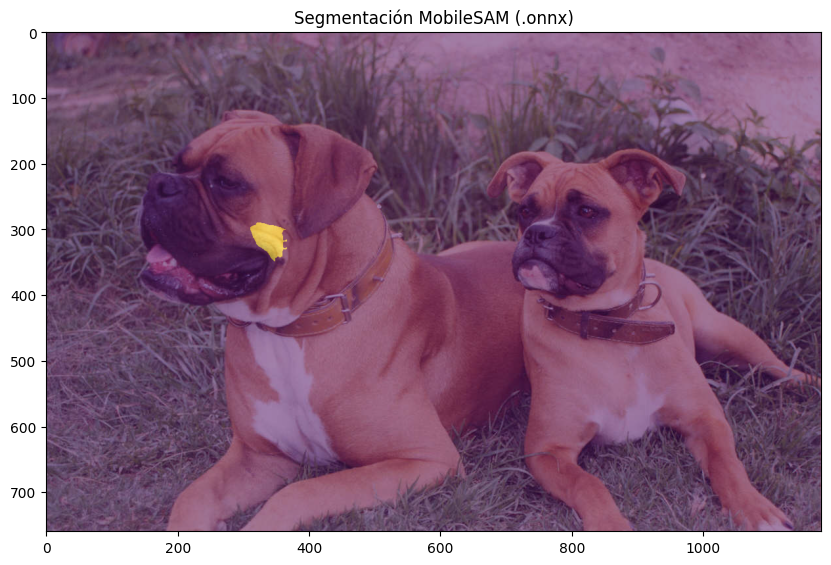

In [ ]:
import matplotlib.pyplot as plt

# Upsample mask to image size
mask = masks[0, 0]
mask = cv2.resize(mask, (w, h))
mask = (mask > 0).astype(np.uint8) * 255

# Visualizar
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask, alpha=0.5)
plt.axis('on')
plt.title("Segmentación MobileSAM (.onnx)")
plt.show()
